In [1]:
#import the picture
import cv2
import numpy as np

import matplotlib.pyplot as plt
import random
#import matplotlib.cm as cm
import pandas as pd

https://www.kaggle.com/models/google/movenet/tensorFlow2/singlepose-lightning/4

https://www.kaggle.com/code/kerneler/movenet-ultra-fast-and-accurate-pose-detection

https://www.tensorflow.org/ https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/hub/tutorials/movenet.ipynb

In [6]:
# convert mp4 file into png files
#%pip install tqdm
#import tqdm

from moviepy.editor import VideoFileClip
import numpy as np
from PIL import Image

# Specify the path of the MP4 file
mp4_file = "VID_20240602_193743.mp4"

# Create a VideoFileClip object
video = VideoFileClip(mp4_file)

# Iterate over each frame in the video and save it as a PNG file
n_interval=8
for i, frame in enumerate(video.iter_frames()):
    if i%n_interval!=0:
        continue
    # Specify the output file name for each frame
    output_file = f"frame_{i//n_interval}.png"
    
    # Convert the frame (numpy array) to an image
    image = Image.fromarray(frame)
    
    # Save the frame as a PNG file
    image.save(output_file)
print("FPS",video.fps/n_interval)

FPS 3.74


In [5]:

# Specify the file path of the image
image_path = "input_trial.jpg"


# Read the image
image_input = cv2.imread(image_path)

# Check if the image was successfully read
if image_input is not None:
    # Image was read successfully
    print("Image read successfully!")
else:
    # Failed to read the image
    print("Failed to read the image.")

Image read successfully!


In [6]:
# import reference points
image_data_path = "input_trial.dat"
with open(image_data_path,"r") as f:
    reference_points = f.readlines()
    reference_points = [x.strip() for x in reference_points]
Ps=np.array([ [float(y) for y in x.split()] for x in reference_points[3:6]])
ps=np.array([ [float(y) for y in x.split()] for x in reference_points[0:3]])
angles=np.array( [float(y) for y in reference_points[7].split()] )
h,w,_=image_input.shape
print(  f'{w=}, {h=}')
ps0=np.array([[(w-1)*0.5,(h-1)*0.5]]*3)
#c: float=int(reference_points[6])*w/36.0
c: float=float(reference_points[6])
Ps,ps,ps0,c,angles

w=5792, h=4344


(array([[ 0.03245207,  0.08904134, -0.36324324],
        [ 0.03245207,  0.24404134, -0.36324324],
        [ 0.30245127,  0.0896994 , -0.36324324]]),
 array([[2381., 4245.],
        [1355., 2855.],
        [4565., 2355.]]),
 array([[2895.5, 2171.5],
        [2895.5, 2171.5],
        [2895.5, 2171.5]]),
 4543.18,
 array([2.47367118, 0.01387682, 2.43153841]))

In [10]:
# copy image_input
image = image_input.copy()

# write 3 circles at ps on the image
for i in range(3):
    image = cv2.circle(image, (int(ps[i][0]), int(ps[i][1])), 25, (0, 0, 255), -1)

#write a line between the each pair of points
for i in range(3):
    image = cv2.line(image, (int(ps[i][0]), int(ps[i][1])), (int(ps[(i+1)%3][0]), int(ps[(i+1)%3][1])), (0, 0, 255), 5)

# write the distance (ds) between the points belong the line above
for i in range(3):
    image = cv2.putText(image, "("+','.join([ f'{Ps[i,j]:0.3f}' for j in range(3)]) + ")", (int(ps[i][0]), int(ps[i][1])), cv2.FONT_HERSHEY_SIMPLEX, 5, (0, 0, 0), 2)
    

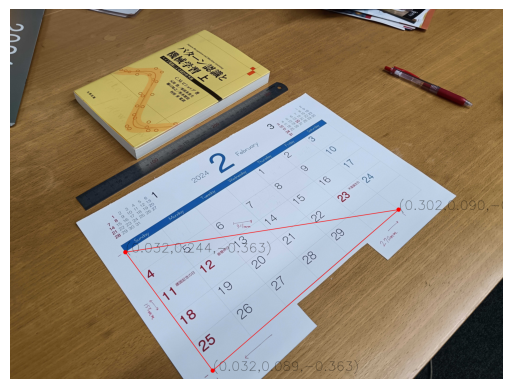

In [11]:
#save the image
cv2.imwrite('output.jpg', image)

# Display the image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [18]:
# Define a RotationMatrix class
# It includes the following attributes:
# -  3 angles defining the rotation matrix. (kappa, phi, omega)
# return the li,mi,ni (i=0,1,2) for te given angles
# 
class RotationMatrix:
    def __init__(self, omega: float, phi: float, kappa: float):
        self.kappa :float = kappa
        self.phi :float = phi
        self.omega :float = omega
        
        self.matrix_x= np.array([[1, 0, 0], [0, np.cos(omega), -np.sin(omega)], [0, np.sin(omega), np.cos(omega)]])
        self.matrix_y= np.array([[np.cos(phi), 0, np.sin(phi)], [0, 1, 0], [-np.sin(phi), 0, np.cos(phi)]])
        self.matrix_z= np.array([[np.cos(kappa), -np.sin(kappa), 0], [np.sin(kappa), np.cos(kappa), 0], [0, 0, 1]])
        self.matrix = self.matrix_z @ self.matrix_y @ self.matrix_x

        self.dmatrix_x_domega= np.array([[0, 0, 0], [0, -np.sin(omega), -np.cos(omega)], [0, np.cos(omega), -np.sin(omega)]])
        self.dmatrix_y_dphi= np.array([[-np.sin(phi), 0, np.cos(phi)], [0, 0, 0], [-np.cos(phi), 0, -np.sin(phi)]])
        self.dmatrix_z_dkappa= np.array([[-np.sin(kappa), -np.cos(kappa), 0], [np.cos(kappa), -np.sin(kappa), 0], [0, 0, 0]])
        self.matrix_domega = self.matrix_z @ self.matrix_y @ self.dmatrix_x_domega
        self.matrix_dphi = self.matrix_z @ self.dmatrix_y_dphi @ self.matrix_x
        self.matrix_dkappa = self.dmatrix_z_dkappa @ self.matrix_y @ self.matrix_x
        
    def __str__(self):
        return f'omega={self.omega}, phi={self.phi}, kappa={self.kappa}\nMatrix={self.matrix}'
    def __repr__(self):
        return self.matrix.__repr__()

# Define a DistanceConstraint class
# It includes the following attributes:
# -  2 points \in R3 defining the distance constraint. (p1, p2)
# -  The distance between the 2 points. (d)
# return the partial derivatives of the distance constraint
#
class DistanceConstraint:
    def __init__(self, X1: np.array, X2: np.array, d: float):
        self.X1 = X1
        self.X2 = X2
        self.dX = X1-X2
        self.d = d
        self.error = self.dX[0]**2 + self.dX[1]**2 - d**2
        self.derror_dxy = np.array([[2*self.dX[0], -2*self.dX[0]],[2*self.dX[1], -2*self.dX[1]]])# [de/dx1, de/dx2], [de/dy1, de/dy2]
        
    def __str__(self):
        return f'error={self.error}'

# Define a ColinearityConstraint class
# It includes the following attributes:
# -  RotationMatrix object
# -  focal length (c)
# -  a pair of points \in R2  on the image and the corresponding 3d points \in R3. (p, X)
# return the partial derivatives of the colinearity constraint
#
class ColinearityConstraint:
    def __init__(self, rotation_matrix: RotationMatrix, c:float , p: np.array, X: np.array):
        self.rotation_matrix = rotation_matrix
        self.p = p
        self.X = X
        self.c= c
        self.inv_c = 1/c
        self.errorXY =np.array([np.dot(rotation_matrix.matrix[:,0], X) - p[0]*self.inv_c*np.dot(rotation_matrix.matrix[:,2], X),
                                 np.dot(rotation_matrix.matrix[:,1], X) - p[1]*self.inv_c*np.dot(rotation_matrix.matrix[:,2], X)]) # [eX, eY]
        self.derrorXY_dxyz = np.array([[ self.rotation_matrix.matrix[i,0] - p[0]*self.inv_c*rotation_matrix.matrix[i,2] for i in range(3)],# [deX/dX, deX/dY, deX/dZ]
                                      [ self.rotation_matrix.matrix[i,1] - p[1]*self.inv_c*rotation_matrix.matrix[i,2] for i in range(3)]])# [deY/dX, deY/dY, deY/dZ]
        # [deX/domega, deY/domega]
        self.derrorXY_domega = np.array([np.dot(self.rotation_matrix.matrix_domega[:,0],X)- p[0]*self.inv_c*np.dot(self.rotation_matrix.matrix_domega[:,2],X),
                                         np.dot(self.rotation_matrix.matrix_domega[:,1],X)- p[1]*self.inv_c*np.dot(self.rotation_matrix.matrix_domega[:,2],X)])
        # [deX/dphi, deY/dphi]
        self.derrorXY_dphi = np.array([np.dot(self.rotation_matrix.matrix_dphi[:,0],X)- p[0]*self.inv_c*np.dot(self.rotation_matrix.matrix_dphi[:,2],X),
                                         np.dot(self.rotation_matrix.matrix_dphi[:,1],X)- p[1]*self.inv_c*np.dot(self.rotation_matrix.matrix_dphi[:,2],X)])
        # [deX/dkappa, deY/dkappa]
        self.derrorXY_dkappa = np.array([np.dot(self.rotation_matrix.matrix_dkappa[:,0],X)- p[0]*self.inv_c*np.dot(self.rotation_matrix.matrix_dkappa[:,2],X),
                                         np.dot(self.rotation_matrix.matrix_dkappa[:,1],X)- p[1]*self.inv_c*np.dot(self.rotation_matrix.matrix_dkappa[:,2],X)])

    def __str__(self):
        return f'errorX={self.errorXY[0]}\n\terrorY={self.errorXY[1]}'


In [52]:
range_x =[-0.1,0.8]
range_y =[0.0,0.6]
N_division_x,N_division_y =(900*4,600*4)
d_x,d_y=(range_x[1]-range_x[0])/N_division_x,(range_y[1]-range_y[0])/N_division_y
image_plane=np.zeros((N_division_y,N_division_x,3),dtype=np.uint8)
R=RotationMatrix(angles[0],angles[1],angles[2])

In [53]:
z_plane=Ps[0,2]
for i,i_x in enumerate(np.arange(range_x[0],range_x[1],d_x)):
    print(i)
    for j,j_y in enumerate(np.arange(range_y[0],range_y[1],d_y)):
        X=np.array([i_x+d_x*0.5,j_y+d_y*0.5,z_plane])
        X_camera=R.matrix.T @ X
        uv=ps0[0,:]-X_camera[(0,1),]*c/X_camera[2]
        uv=uv.astype(int)
        if uv[0]>=0 and uv[0]<w and uv[1]>=0 and uv[1]<h:
            image_plane[j,i]=image_input[uv[1],uv[0],:]
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

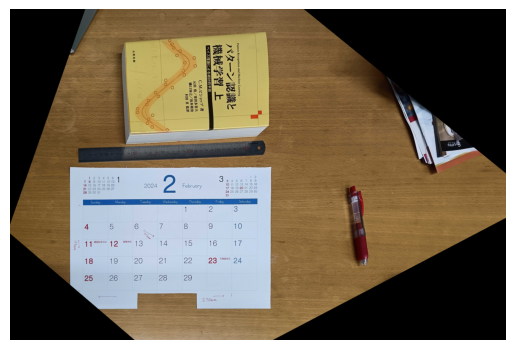

In [54]:
# Save the image
cv2.imwrite('output_plane.jpg', image_plane[::-1])

# Display the image
plt.imshow(cv2.cvtColor(image_plane[::-1], cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()